In [1]:
!pip3.10.9 install -q transformers
!pip3.10.9 install -q pytorch_model_summary
!pip3.10.9 install -q torchmetrics
!pip3.10.9 install -q pandas
!pip3.10.9 install -q torchvision
!pip3.10.9 install -q matplotlib albumentations scikit-image nltk tqdm

In [ ]:
import json
import torch
from transformers import pipeline, ViTImageProcessor, ViTForImageClassification, ViTModel, AutoTokenizer, MBartModel,MBartForConditionalGeneration
from transformers import T5Tokenizer, T5Model
import pandas as pd
from torchvision.io import read_image
from PIL import Image
from torchvision import transforms as transforms
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import albumentations as A
from albumentations import Compose
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from tqdm import tqdm
import torch.nn.functional as F
from nltk.translate.bleu_score import sentence_bleu
import string
from torchmetrics import F1Score
from typing import Optional, Tuple, Union
from transformers.modeling_outputs import Seq2SeqLMOutput
import os
import gc

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from huggingface_hub import snapshot_download
snapshot_download(repo_id='uitnlp/OpenViVQA-dataset', repo_type="dataset",
                    local_dir=".",
                    local_dir_use_symlinks="auto"
                )
import zipfile
with zipfile.ZipFile("train-images.zip","r") as zip_ref:
    zip_ref.extractall(".")
with zipfile.ZipFile("dev-images.zip","r") as zip_ref:
    zip_ref.extractall(".")
with zipfile.ZipFile("test-images.zip","r") as zip_ref:
    zip_ref.extractall(".")

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.59k [00:00<?, ?B/s]

vlsp2023_dev_data.json:   0%|          | 0.00/762k [00:00<?, ?B/s]

vlsp2023_test_data.json:   0%|          | 0.00/2.50M [00:00<?, ?B/s]

train-images.zip:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

data_examples.png:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

vlsp2023_train_data.json:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

dev-images.zip:   0%|          | 0.00/165M [00:00<?, ?B/s]

test-images.zip:   0%|          | 0.00/152M [00:00<?, ?B/s]

In [ ]:
class OPENVIVQA_Dataset(torch.utils.data.Dataset):
    """
    Dataset class for the OPENVIVQA dataset.
    """
    def __init__(self, annotation_file, img_dir):
        with open(annotation_file, encoding='utf-8') as f:
            json_file = json.load(f)

        # Flatten the annotations into a list of dictionaries
        annotations = [{'id': annot_id, **data} for annot_id, data in json_file['annotations'].items()]
        self.annotations = pd.DataFrame(annotations)

        # Convert image_id to the correct type (if necessary)
        self.annotations['image_id'] = self.annotations['image_id'].astype(str)

        # Creating img_reference DataFrame
        img_reference = [{'image_id': img_id, 'filename': filename} for img_id, filename in json_file['images'].items()]
        self.img_reference = pd.DataFrame(img_reference)

        # Convert image_id in img_reference to the same type as in annotations
        self.img_reference['image_id'] = self.img_reference['image_id'].astype(str)

        self.img_dir = img_dir
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
            transforms.ToTensor()           # Convert the image to a tensor
        ])
    def __len__(self):
        return len(self.annotations) // 40

    def __getitem__(self, idx):
        annot = self.annotations.iloc[idx]
        annot_id = annot['id']
        image_id = annot['image_id']
        question = annot['question']
        answer = annot['answer']

        # Fetching the filename
        img_file = self.img_reference[self.img_reference['image_id'] == image_id]['filename'].iloc[0]

        # Load the image
        img_path = os.path.join(self.img_dir, img_file)
        img = Image.open(img_path).convert('RGB')

        img = self.transform(img)

        return {
            'id': annot_id,
            'question': question,
            'answer': answer,
            'image': img
        }

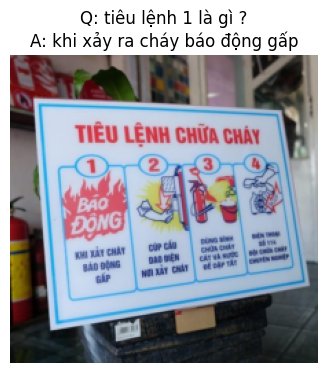

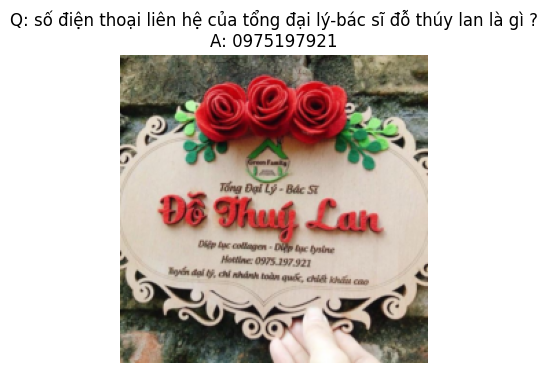

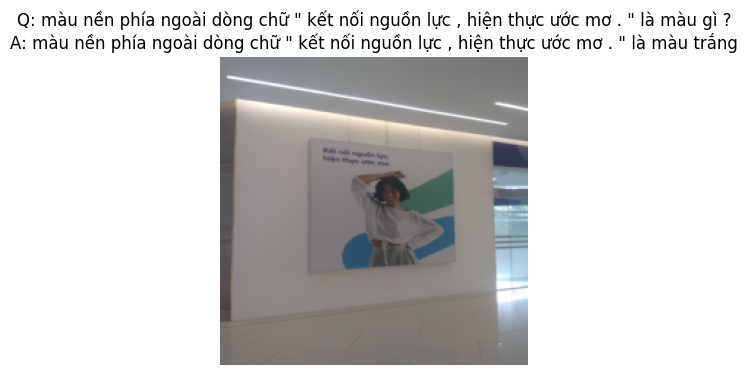

In [ ]:
dataset = OPENVIVQA_Dataset('./vlsp2023_dev_data.json', 'dev-images')

# Create a DataLoader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Function to visualize a batch of data
def visualize_batch(batch):
    plt.figure(figsize=(12, 4))
    for i in range(len(batch['image'])):
        ax = plt.subplot(1, len(batch['image']), i + 1)
        img = batch['image'][i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        plt.imshow(img)
        plt.title(f"Q: {batch['question'][i]}\nA: {batch['answer'][i]}")
        plt.axis('off')
    plt.show()

# Iterate and visualize the first few batches
num_batches_to_visualize = 3
for i, batch in enumerate(data_loader):
    if i >= num_batches_to_visualize:
        break
    visualize_batch(batch)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
image_encoder = ViTModel.from_pretrained('google/vit-base-patch16-224').to(device)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("facebook/mbart-large-cc25")
text_model = MBartModel.from_pretrained("facebook/mbart-large-cc25").to(device)

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

In [ ]:
def shift_tokens_right(input_ids: torch.Tensor, pad_token_id: int):
    """
    Shift input ids one token to the right, and wrap the last non pad token (the <LID> token). Note that MBart does not
    have a single `decoder_start_token_id` in contrast to other Bart-like models.
    """
    # Ensure input_ids is 2D (batch_size, sequence_length)
    prev_output_tokens = input_ids.clone()

    if pad_token_id is None:
        raise ValueError("pad_token_id has to be defined.")

    # Replace possible -100 values in labels by `pad_token_id`
    prev_output_tokens.masked_fill_(prev_output_tokens == -100, pad_token_id)

    # Calculate index_of_eos with ensuring 2D shape
    index_of_eos = (prev_output_tokens.ne(pad_token_id).sum(dim=1) - 1).unsqueeze(-1)
    decoder_start_tokens = prev_output_tokens.gather(1, index_of_eos).squeeze()
    prev_output_tokens[:, 1:] = prev_output_tokens[:, :-1].clone()
    prev_output_tokens[:, 0] = decoder_start_tokens

    return prev_output_tokens


In [ ]:
# Build the mVQA model. Some of the codes are modified from the source code of mBART at hugging face.
class VQAModel2(nn.Module):
    """
    The VQAModel should consist of a image encoder and a multilingual language transformer (encoder, decoder, encoder-decoder).

    The visual_text_block is a module that integrates the encodings from the images and text.
    """

    def __init__(self, visualEncoder, textModel, vocab_size = 250027, img_hidden_dim = 768, txt_hidden_dim = 1024):
        super(VQAModel2, self).__init__()
        self.visualEncoder = visualEncoder
        self.config = textModel.config
        self.encoder = textModel.encoder
        self.decoder = textModel.decoder
        self.vocab_size = vocab_size
        # Add a linear layer to change dim of image encoding if img_hidden_dim and txt_hidden_dim do not match.
        if img_hidden_dim != txt_hidden_dim:
            self.needConvert = True
            self.dim_change = nn.Linear(img_hidden_dim, txt_hidden_dim)
        # lm_head convert text in hidden state after decoder to logits
        self.lm_head = nn.Linear(txt_hidden_dim, out_features= vocab_size, bias=False) #250027 is the vocab size for mBART
        # Cross entropy loss, ignore padding index.
        self.loss_fn = nn.CrossEntropyLoss(ignore_index = -100)
        # Logit bias of mBART
        self.register_buffer("final_logits_bias", torch.zeros((1, vocab_size)))


    def forward(
        self,
        input_ids: torch.LongTensor = None,
        pixel_values: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
     ):
        """
          question_input_ids - tokenized input question
          pixel_values - preprocessed image
          labels - resulting tokens from input
        """

        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states)

        if input_ids is not None and input_ids.ndim == 1:
            input_ids = input_ids.unsqueeze(0)

        if attention_mask is not None and attention_mask.ndim == 1:
            attention_mask = attention_mask.unsqueeze(0)

        # Different to other models, MBart automatically creates decoder_input_ids from
        # input_ids if no decoder_input_ids are provided
        if decoder_input_ids is None and decoder_inputs_embeds is None:
            decoder_input_ids = shift_tokens_right(input_ids, self.config.pad_token_id)


        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if encoder_outputs is None:
            encoder_outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            )

        # Image encoding
        image_encoder_outputs = self.visualEncoder(pixel_values)
        if self.needConvert:
            image_state = self.dim_change(image_encoder_outputs['last_hidden_state'])
        else:
            image_state = image_encoder_outputs['last_hidden_state']

        # Concatneante image encoding and text encoding, built relative attention mask.
        img_mask = torch.ones((image_state.shape[0], image_state.shape[1])).to(device)
        hidden_states = torch.cat([image_state, encoder_outputs[0]], dim = 1).to(device)
        attention_mask = torch.cat([img_mask, attention_mask], dim = 1).to(device)

        # Decode
        decoder_outputs = self.decoder(
                input_ids=decoder_input_ids,
                attention_mask=decoder_attention_mask,
                encoder_hidden_states = hidden_states,
                encoder_attention_mask = attention_mask,
                head_mask=decoder_head_mask,
                cross_attn_head_mask=cross_attn_head_mask,
                past_key_values=past_key_values,
                inputs_embeds=decoder_inputs_embeds,
                use_cache=use_cache,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )

        # The logits of generated answer, in the shape of BatchNumber * hidden_state_size * vocab_size
        lm_logits = self.lm_head(decoder_outputs[0]) + self.final_logits_bias

        out = {
                "logits": lm_logits,
                "hidden_states": decoder_outputs['last_hidden_state']
            }

        # Calculate cross entropy loss (need to ignore paddings).
        if labels is not None:
            labels = labels.to(lm_logits.device)
            loss = self.loss_fn(lm_logits.view(-1, lm_logits.size(-1)), labels.view(-1))
            out["loss"] = loss

        return out

In [ ]:
model = VQAModel2(image_encoder, text_model).to(device)

In [ ]:
from pytorch_model_summary import summary
print(summary(model, torch.zeros((2,60)).long().to(device),
              torch.zeros((2,3,224,224)).to(device),
              torch.zeros((2,60)).long().to(device),
              torch.zeros((2,60)).long().to(device),
              show_input=True))

------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
    MBartEncoder-1                          408,237,056     408,237,056
        ViTModel-2     [2, 3, 224, 224]      86,389,248      86,389,248
          Linear-3        [2, 197, 768]         787,456         787,456
    MBartDecoder-4                          458,642,432     458,642,432
          Linear-5        [2, 60, 1024]     256,027,648     256,027,648
Total params: 1,210,083,840
Trainable params: 1,210,083,840
Non-trainable params: 0
------------------------------------------------------------------------


In [ ]:
class MultimodalCollator:
    def __init__(self, tokenizer: AutoTokenizer):
        self.tokenizer = tokenizer

    def tokenize_text(self, texts):
        encoded_text = self.tokenizer(
            text=texts,
            max_length=60,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True)

        # Avoid squeezing if batch size is 1
        return {
            "input_ids": encoded_text['input_ids'],
            "attention_mask": encoded_text['attention_mask']
        }

    def tokenize_answer(self, texts):
        encoded_text = self.tokenizer(
            text=texts,
            max_length=60,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True)

        encoded_text['input_ids'][encoded_text['input_ids'] == 1] = -100

        # Avoid squeezing if batch size is 1
        return {
            "labels": encoded_text['input_ids']
        }

    def preprocess_images(self, images):
        # Ensure that images is a tensor
        images = torch.stack(images) if not isinstance(images, torch.Tensor) else images
        return {
            "pixel_values": images
        }

    def __call__(self, examples):
        # Check if input is a single example or a batch
        if isinstance(examples, dict):  # Single example
            questions = [examples['question']]
            answers = [examples['answer']]
            images = [examples['image']]
        else:  # Batch of examples
            questions = [ex['question'] for ex in examples]
            answers = [ex['answer'] for ex in examples]
            images = torch.stack([ex['image'] for ex in examples])

        return {
            **self.tokenize_text(questions),
            **self.tokenize_answer(answers),
            **self.preprocess_images(images)
        }

In [ ]:
collate_fn = MultimodalCollator(tokenizer)

In [ ]:
train_dataset = OPENVIVQA_Dataset('./vlsp2023_train_data.json', 'training-images')
val_dataset = OPENVIVQA_Dataset('./vlsp2023_dev_data.json', 'dev-images')
test_dataset = OPENVIVQA_Dataset('./vlsp2023_test_data.json', 'test-images')

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle = True, num_workers = 8, collate_fn = collate_fn)
val_loader = DataLoader(dataset=val_dataset, batch_size=4, shuffle = False, num_workers = 8, collate_fn = collate_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle = False, num_workers = 8, collate_fn = collate_fn)

In [ ]:
# Setting up training parameters
num_epochs = 12
learning_rate = 1e-5
scale = 1
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index = -100)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.5)

In [ ]:
# Directory to save checkpoints
model_outputs = "saved_models"

In [ ]:
from tqdm import tqdm

def train(model, train_loader, val_loader, optimizer, criterion, num_epochs, scheduler):
    train_loss = []
    val_loss = []
    train_f1 = []
    val_f1 = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss, running_train_f1 = 0, 0
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [TRAIN]')
        for batch_dict in train_bar:
            # Move the inputs and targets to the device (CPU or GPU)
            input_ids = batch_dict['input_ids'].to(device)
            pixel_values = batch_dict['pixel_values'].to(device)
            attention_mask = batch_dict['attention_mask'].to(device)
            labels = batch_dict['labels'].to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(input_ids, pixel_values, attention_mask, labels=labels)
            loss = outputs['loss']

            f1 = F1Score(task="multiclass", num_classes=250027, top_k=1, ignore_index=-100).to(device)
            s = f1(outputs['logits'].argmax(dim=2), labels)

            running_train_loss += loss.item()
            running_train_f1 += s.clone().cpu().numpy()

            train_bar.set_postfix(loss=running_train_loss / (train_bar.n + 1),
                                  f1=running_train_f1 / (train_bar.n + 1))

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        epoch_train_loss = running_train_loss / len(train_loader)
        epoch_train_f1 = running_train_f1 / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_f1.append(epoch_train_f1)

        # Use learning scheduler
        scheduler.step()

        # Test on validation dataset
        model.eval()
        running_val_loss, running_val_f1 = 0, 0
        val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [VAL]')
        with torch.no_grad():
            for batch_dict in val_bar:
                input_ids = batch_dict['input_ids'].to(device)
                pixel_values = batch_dict['pixel_values'].to(device)
                attention_mask = batch_dict['attention_mask'].to(device)
                labels = batch_dict['labels'].to(device)

                outputs = model(input_ids, pixel_values, attention_mask, labels=labels)

                lm_logits = outputs['logits']
                labels = labels.to(lm_logits.device)
                loss = criterion(lm_logits.view(-1, lm_logits.size(-1)), labels.view(-1))

                # Compute f1_score
                f1 = F1Score(task="multiclass", num_classes=250027, top_k=1, ignore_index=-100).to(device)
                s = f1(lm_logits.argmax(dim=2), labels)
                running_val_loss += loss.item()
                running_val_f1 += s.clone().cpu().numpy()

                # Update tqdm bar
                val_bar.set_postfix(loss=running_val_loss / (val_bar.n + 1),
                                    f1=running_val_f1 / (val_bar.n + 1))

        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_f1 = running_val_f1 / len(val_loader)
        val_loss.append(epoch_val_loss)
        val_f1.append(epoch_val_f1)


        print("Epoch [{}/{}], Train Loss: {:.4f}, Train F1: {:.4f}, LearningRate: {} ".format(epoch+1, num_epochs, epoch_train_loss, epoch_train_f1, scheduler.get_last_lr()))
        print("Epoch [{}/{}], Val Loss: {:.4f}, Val F1: {:.4f}".format(epoch+1, num_epochs, epoch_val_loss, epoch_val_f1))

        # Save the trained model
        # if (epoch+1) > 0:
        #     torch.save(model.state_dict(), model_outputs + "/ViTmBART_epoch" + str(epoch+19) + ".pth")

    return model, train_loss, val_loss, train_f1, val_f1

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model, train_loss, val_loss, train_f1, val_f1 = train(model, train_loader, val_loader, optimizer, criterion, num_epochs, lr_scheduler)

Epoch 1/12 [VAL]:   0%|          | 0/22 [00:02<?, ?it/s, f1=2.24, loss=192]  

Epoch [1/12], Train Loss: 9.8950, Train F1: 0.0960, LearningRate: [1e-05] 
Epoch [1/12], Val Loss: 8.7177, Val F1: 0.1016



Epoch 2/12 [TRAIN]: 100%|██████████| 193/193 [00:51<00:00,  3.76it/s, f1=0.113, loss=6.84]

Epoch 1/12 [VAL]:   0%|          | 0/22 [00:53<?, ?it/s, f1=2.24, loss=192]

Epoch 2/12 [VAL]:   0%|          | 0/22 [00:02<?, ?it/s, f1=2.18, loss=172]

Epoch [2/12], Train Loss: 6.8381, Train F1: 0.1125, LearningRate: [1e-05] 
Epoch [2/12], Val Loss: 7.8062, Val F1: 0.0991


Epoch 3/12 [VAL]:   0%|          | 0/22 [00:02<?, ?it/s, f1=2.62, loss=163]  

Epoch [3/12], Train Loss: 5.9049, Train F1: 0.1344, LearningRate: [1e-05] 
Epoch [3/12], Val Loss: 7.4195, Val F1: 0.1190



Epoch 4/12 [TRAIN]: 100%|██████████| 193/193 [00:51<00:00,  3.74it/s, f1=0.17, loss=5.15]

Epoch 3/12 [VAL]:   0%|          | 0/22 [00:53<?, ?it/s, f1=2.62, loss=163]

Epoch 4/12 [VAL]:   0%|          | 0/22 [00:02<?, ?it/s, f1=2.64, loss=167]

Epoch [4/12], Train Loss: 5.1469, Train F1: 0.1697, LearningRate: [1e-05] 
Epoch [4/12], Val Loss: 7.5741, Val F1: 0.1199


Epoch 5/12 [VAL]:   0%|          | 0/22 [00:02<?, ?it/s, f1=2.42, loss=171]  

Epoch [5/12], Train Loss: 4.4470, Train F1: 0.2112, LearningRate: [5e-06] 
Epoch [5/12], Val Loss: 7.7501, Val F1: 0.1098



Epoch 6/12 [TRAIN]: 100%|██████████| 193/193 [00:50<00:00,  3.81it/s, f1=0.28, loss=3.66]

Epoch 5/12 [VAL]:   0%|          | 0/22 [00:52<?, ?it/s, f1=2.42, loss=171]

Epoch 6/12 [VAL]:   0%|          | 0/22 [00:02<?, ?it/s, f1=2.6, loss=172] 

Epoch [6/12], Train Loss: 3.6620, Train F1: 0.2801, LearningRate: [5e-06] 
Epoch [6/12], Val Loss: 7.8066, Val F1: 0.1180


Epoch 7/12 [VAL]:   0%|          | 0/22 [00:02<?, ?it/s, f1=2.67, loss=179]  

Epoch [7/12], Train Loss: 3.1681, Train F1: 0.3321, LearningRate: [5e-06] 
Epoch [7/12], Val Loss: 8.1331, Val F1: 0.1212



Epoch 8/12 [TRAIN]: 100%|██████████| 193/193 [00:51<00:00,  3.76it/s, f1=0.387, loss=2.82]

Epoch 7/12 [VAL]:   0%|          | 0/22 [00:53<?, ?it/s, f1=2.67, loss=179]

Epoch 8/12 [VAL]:   0%|          | 0/22 [00:02<?, ?it/s, f1=2.59, loss=180]

Epoch [8/12], Train Loss: 2.8166, Train F1: 0.3865, LearningRate: [5e-06] 
Epoch [8/12], Val Loss: 8.1741, Val F1: 0.1177


Epoch 9/12 [VAL]:   0%|          | 0/22 [00:02<?, ?it/s, f1=2.61, loss=186]  

Epoch [9/12], Train Loss: 2.5395, Train F1: 0.4239, LearningRate: [5e-06] 
Epoch [9/12], Val Loss: 8.4343, Val F1: 0.1187



Epoch 10/12 [TRAIN]: 100%|██████████| 193/193 [00:51<00:00,  3.77it/s, f1=0.467, loss=2.31]

Epoch 9/12 [VAL]:   0%|          | 0/22 [00:53<?, ?it/s, f1=2.61, loss=186]

Epoch 10/12 [VAL]:   0%|          | 0/22 [00:02<?, ?it/s, f1=2.74, loss=188]

Epoch [10/12], Train Loss: 2.3055, Train F1: 0.4669, LearningRate: [2.5e-06] 
Epoch [10/12], Val Loss: 8.5431, Val F1: 0.1248


Epoch 11/12 [VAL]:   0%|          | 0/22 [00:02<?, ?it/s, f1=2.74, loss=190]  

Epoch [11/12], Train Loss: 2.0671, Train F1: 0.5213, LearningRate: [2.5e-06] 
Epoch [11/12], Val Loss: 8.6411, Val F1: 0.1244



Epoch 12/12 [TRAIN]: 100%|██████████| 193/193 [00:51<00:00,  3.77it/s, f1=0.557, loss=1.92]

Epoch 11/12 [VAL]:   0%|          | 0/22 [00:53<?, ?it/s, f1=2.74, loss=190]

Epoch 12/12 [VAL]:   0%|          | 0/22 [00:02<?, ?it/s, f1=2.67, loss=197]

Epoch [12/12], Train Loss: 1.9210, Train F1: 0.5575, LearningRate: [2.5e-06] 
Epoch [12/12], Val Loss: 8.9418, Val F1: 0.1213


In [ ]:
from torchmetrics import F1Score
from nltk.translate import bleu
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4

In [ ]:
def bleu_score(reference, candidate):
  # ignore punctuations
    reference = reference.translate(str.maketrans('', '', string.punctuation))
    candidate = candidate.translate(str.maketrans('', '', string.punctuation))

    ref_list = reference.split()
    can_list = candidate.split()

    score = bleu([ref_list], can_list,smoothing_function=smoothie, weights = [0.25,0.25,0.25,0.25])
    return score


In [ ]:
def test_eval(test_data, model):
    f1_torchmetric, bleu_l, pred_token_l, pred_word_l = [],[],[],[]

    model.eval()
    with torch.no_grad():
        for i in range(len(test_data)):
            data = test_data.__getitem__(i)
            image, question, answer = data['image'], data['question'], data['answer']
            image = image.to(device)

            question_tok = tokenizer(question, max_length = 60, padding='max_length',return_tensors="pt", return_attention_mask = True)
            input_ids = question_tok["input_ids"].to(device)
            attention_mask = question_tok["attention_mask"].to(device)
            answer_tok = tokenizer(answer, max_length = 60, padding='max_length',return_tensors="pt")['input_ids']
            answer_tok[answer_tok == 1] = -100
            answer_tok = answer_tok.to(device)
            output = model(input_ids = input_ids, pixel_values = image.unsqueeze(0), attention_mask = attention_mask)

            logit = output['logits']
            pred = logit.argmax(dim =2)
            pred_token_l.append(pred.clone().cpu())
            pred_word = tokenizer.batch_decode(pred, skip_special_tokens=True)[0]
            pred_word_l.append(pred_word)

            # F1 score from torch.metric
            f1 = F1Score(task="multiclass", num_classes=250027, top_k = 1, ignore_index = -100).to(device)
            s3 = f1(pred, answer_tok)
            f1_torchmetric.append(s3)

            # Compute bleu score
            s2 = bleu_score(answer,pred_word)
            bleu_l.append(s2)
    return f1_torchmetric, bleu_l, pred_token_l, pred_word_l

In [ ]:
f1_torchmetric, bleu_l, pred_token_l, pred_word_l = test_eval(val_dataset,model)

In [ ]:
print("average f1 score: ", sum(f1_torchmetric)/len(f1_torchmetric))
print("average bleu score: ", sum(bleu_l)/len(bleu_l))

average f1 score:  tensor(0.1286, device='cuda:0')
average bleu score:  0.012897643949529908


In [ ]:
def plot_img_test(no_, dataset):
    images, questions, answers, answer_tokens, predictions, pred_tokens, f1_tm_lst, bleu_lst = [],[],[],[],[],[],[],[]
    random_idx = np.random.choice(len(dataset),no_)
    for i in random_idx:
        data = dataset.__getitem__(i)
        image, question, answer = data['image'], data['question'], data['answer']
        images.append(image.permute(1, 2, 0))
        questions.append(question)
        answers.append(answer)

        question_tok = tokenizer(question, max_length = 60, padding='max_length',return_tensors="pt", return_attention_mask = True)
        input_ids = question_tok["input_ids"].to(device)
        attention_mask = question_tok["attention_mask"].to(device)
        answer_tok = tokenizer(answer, max_length = 60, padding='max_length',return_tensors="pt")["input_ids"].to(device)
        answer_tokens.append(answer_tok)
        answer_tok[answer_tok == 1] = -100

        output = model(input_ids, pixel_values = image.unsqueeze(0).to(device), attention_mask = attention_mask)
        logit = output['logits']
        pred = logit.argmax(dim =2)
        pred_tokens.append(pred)
        pred_word = tokenizer.batch_decode(pred, skip_special_tokens=True)[0]
        predictions.append(pred_word)

        pred[pred == 1] = -100
        f1 = F1Score(task="multiclass", num_classes=250027, top_k = 1, ignore_index = -100).to(device)
        s3 = f1(pred, answer_tok)
        f1_tm_lst.append(s3)
        s2 = bleu_score(answer,pred_word)
        bleu_lst.append(s2)

        print('\n Q: ' + question + '\n A: '+ answer + '\n Pred: '+ pred_word)

    print("\n F1 torchmetric",f1_tm_lst)
    print("\n Bleu_score",bleu_lst)


    # plt.figure(figsize=(10,6))
    plt.figure(figsize=(10, 10 * no_))  # Adjust figsize for better display
    for idx in range(no_):
        image = images[idx]
        plt.subplot(1, no_, idx+1)
        plt.imshow(image)
        plt.rcParams.update({'font.size': 8})
        plt.title('Q: ' + questions[idx] + '\n A: '+ answers[idx] + '\n Pred: '+ predictions[idx] + '\n')
        plt.axis('off')
        plt.subplots_adjust(left=0.1,
                      bottom=0.1,
                      right=0.9,
                      top=0.9,
                      wspace=1.8,
                      hspace=1.8)
    plt.show()

    return answers, answer_tokens, predictions, pred_tokens, f1_tm_lst, bleu_lst


 Q: đại lý internet có tên là gì ?
 A: tên là trung nguyên
 Pred: có, có có một là có

 Q: nhà hàng có tên gì ?
 A: nhà hàng có tên góc hà nội
 Pred: có hoàngm ba có

 Q: sản phẩm của đào tiên được làm tại đâu ?
 A: sản phẩm của đào tiên được làm tại vietnam
 Pred: có nhiều công

 F1 torchmetric [tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0.0909, device='cuda:0')]

 Bleu_score [0.03759340464156993, 0.028830051881449627, 0]


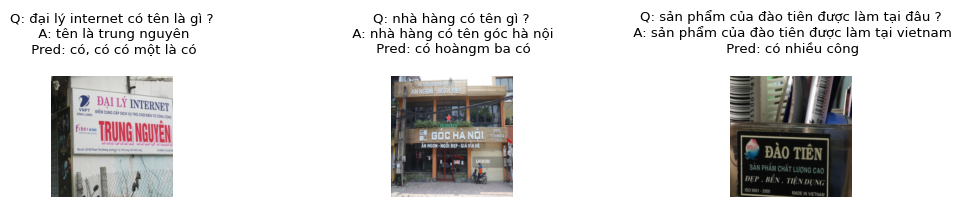

In [ ]:
answers, answer_tokens, predictions, pred_tokens, f1_tm_lst, bleu_lst = plot_img_test(3,val_dataset)


 Q: có bao nhiêu cây cờ ?
 A: có chín cây
 Pred: có chín cây có

 Q: bạn nữ này đang làm gì ?
 A: đang chọn mua bưu thiếp
 Pred: có chọn mua bưu thiếp có

 Q: ngọn đèn đằng xa tỏa ra ánh sáng màu gì ?
 A: ngọn đèn đằng xa tỏa ra ánh sáng màu trắng
 Pred: có đèn đằng xa tỏa ra ánh màu màu trắng có

 F1 torchmetric [tensor(1., device='cuda:0'), tensor(0.8889, device='cuda:0'), tensor(0.8462, device='cuda:0')]

 Bleu_score [0.43146827293898643, 0.5081327481546147, 0.5193071778680676]


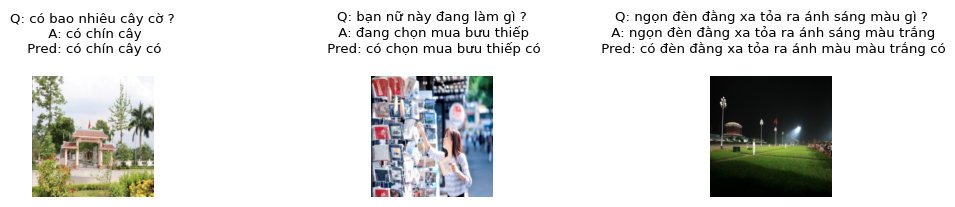

In [ ]:
answers, answer_tokens, predictions, pred_tokens, f1_tm_lst, bleu_lst = plot_img_test(3,train_dataset)